In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qctrlvisualizer import get_qctrl_style, plot_controls

from qctrl import Qctrl

plt.style.use(get_qctrl_style())

# Sparse matrix imports
from scipy.sparse import coo_matrix

# Starting a session with the API
qctrl = Qctrl()

### More realistic qubits, gates and measurements (the reality)

Let's make this model more realistic and include some noise and errors. We won't give a complete mathematical model because it will get too complicated. Instead, we will provide a list of the additional complications we are going to add to the model then jump straight to the code itself.

1. In realistic superconducting devices the Rabi rate that you drive the qubit with is not normally known. Instead you normally set some voltages on your microwave signal generator and you have to figure out how they relate to the Rabi rate. These are usually normalized between -1 and 1. To learn how to determine the Rabi rate of your qubit have a look at the [Pulse calibration application note](https://docs.q-ctrl.com/boulder-opal/application-notes/control-hardware-pulse-calibration).

2. One step we didn't talk about is tuning your microwave on resonance with your superconducting qubit. Even after tuning your microwave drive to be on resonance with your microwave drive, there might be a small detuning error that can drift slowly over time. This manifests as an extra term in the Hamiltonian that looks like:
    $$
    \frac{H(t)}{\hbar} = \epsilon_D(t) b^\dagger b + \frac{1}{2} \Omega(t) b + \frac{1}{2} \Omega(t) b^\dagger 
    $$
    For most experiments this $\epsilon_D(t)$ changes so slowly that they can be treated as effectively constant for a single experiment.  
    
3. Even after calibrating your Rabi rate, there can also be a small amplitude error in the $I$ and $Q$ channels that make up your complex Rabi rate. These errors can be independent and look like:
    $$
    \frac{H(t)}{\hbar} = \frac{1}{2} (I(t)(1 + \epsilon_I(t)) + Q(t)(1 + \epsilon_Q(t))) b + \mbox{ h. c. } 
    $$
    where h. c. means hermitian conjugate of the previous term. Again, $\epsilon_I(t)$ and $\epsilon_Q(t)$ change so slowly that they can be basically treated as effectively constant for a single experiment.  

4. When using superconducting qubits, microwaves are typically sent down control lines that have bandwidth limits. This means that signals with sudden changes tend not to work very well when used on a real device. We can add these bandwidth limits onto any control lines in BOULDER OPAL using the linear filter feature. To learn more about this feature have a look at the [Pulse optimization under realistic experimental constraints application note](https://docs.q-ctrl.com/boulder-opal/application-notes/control-hardware-pulse-optimization-under-realistic-experimental-constraints)

5. Another critical issue on quantum computers is state preparation and measurement (SPAM) errors. These occur when the qubit is not perfectly prepared in the ground state at the beginning of computation, this often gets worse when the quantum computer heats up. There can also be many errors introduced during the measurement state. Superconducting qubits make measurements by driving a resonator that is coupled to the qubit, the state of the qubit affects the frequency of the resonator, which allows us to read out the qubits state. This process is not perfect and sometimes a 1 is incorrectly detected as a 0 and vice versa. These errors are best modeled using a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). 

## Example: CRAB optimization

In **c**hopped **ra**ndom **b**asis (CRAB) optimization, pulses are defined via optimizable linear combinations from a set of basis functions, which can greatly reduce the dimensionality of the optimization search space. Traditionally, a [randomized Fourier basis](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.106.190501) is used, although the same technique has also seen success with other bases, for example [Slepian functions](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.97.062346). In this example, we perform a CRAB optimization (in the Fourier basis) of a qutrit system in which we effect a single-qubit gate while minimizing leakage out of the computational subspace. The system is described by the following Hamiltonian:

\begin{align*}
H(t) = & \frac{\chi}{2} (a^\dagger)^2 a^2 + \gamma(t) (1+\beta(t))a + \gamma^*(t)(1+\beta(t)) a^\dagger + \frac{\alpha(t)}{2} a^\dagger a \,, 
\end{align*}

where $\chi$ is the anharmonicity, $\gamma(t)$ and $\alpha(t)$ are, respectively, complex and real time-dependent pulses, $\beta$ is a small, slowly-varying stochastic amplitude noise process, and $a = |0 \rangle \langle 1 | + \sqrt{2} |1 \rangle \langle 2 |$.

The Q-CTRL optimization engine provides a convenience function, [`qctrl.operations.real_fourier_pwc_signal`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Operations/real_fourier_pwc_signal.html), for creating optimizable signals in a Fourier basis, suitable for use in a CRAB optimization. Other bases are supported by the framework, but require the user to manually provide operations that compute the appropriate linear combinations.

In [19]:
# 2. Dephasing error
dephasing_error = -2 * 2 * np.pi  # MHz

# 3. Amplitude error
amplitude_i_error = 0.98
amplitude_q_error = 1.03

# 4. Control line bandwidth limit
cut_off_frequency = 2 * np.pi * 10  # MHz
resample_segment_count = 1000

# 5. SPAM error confusion matrix
confusion_matrix = np.array([[0.99, 0.01], [0.02, 0.98]])

# Lowering operator
b = np.array([[0, 1], [0, 0]])
# Number operator
n = np.diag([0, 1])
# Initial state
initial_state = np.array([[1], [0]])

sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])
sigma_m = np.array([[0, 1], [0, 0]])
hadamard = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
hadamard_leak = np.array(
    [[1.0, 1.0, 0], [1.0, -1.0, 0], [0, 0, np.sqrt(2)]], dtype=np.complex
) / np.sqrt(2)
qubit_projector = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 0]], dtype=np.complex)
sigma_x_leak = np.array(
[[0, 1.0, 0], [1.0, 0, 0], [0, 0, 1.]], dtype=np.complex)

<ipython-input-19-1378c6337fe9>:28: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  [[1.0, 1.0, 0], [1.0, -1.0, 0], [0, 0, np.sqrt(2)]], dtype=np.complex
<ipython-input-19-1378c6337fe9>:30: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  qubit_projector = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 0]], dtype=np.complex)
<ipython

In [32]:
def get_optimal_pulse(target_U, duration=1):

    # 1. Limits for drive amplitudes
#     max_drive_amplitude = 2 * np.pi * 20  # MHz

    with qctrl.create_graph() as graph:

#         gamma_max = 2 * np.pi * 30e6  # Hz
#         alpha_max = 2 * np.pi * 30e6  # Hz
        segment_count = 20
        gamma_max = 2 * np.pi * 20  # MHz

#         gamma_i = qctrl.operations.bounded_optimization_variable(
#             count=segment_count,
#             lower_bound=-gamma_max,
#             upper_bound=gamma_max,
#         )
#         gamma_i = qctrl.operations.pwc_signal(
#             values=gamma_i,
#             duration=duration,
#         )
#         gamma_q = qctrl.operations.bounded_optimization_variable(
#             count=segment_count,
#             lower_bound=-gamma_max,
#             upper_bound=gamma_max,
#         )
#         gamma_q = qctrl.operations.pwc_signal(
#             values=gamma_q,
#             duration=duration,
#         )
        
        gamma_i = qctrl.operations.real_fourier_pwc_signal(
        duration=duration,
        segments_count=segment_count,
        randomized_frequencies_count=10,
        )
        gamma_q = qctrl.operations.real_fourier_pwc_signal(
            duration=duration,
            segments_count=segment_count,
            optimizable_frequencies_count=10,
        )

        # Apply 4. bandwidth limits
        drive_unfiltered = qctrl.operations.pwc_signal(duration=duration,
                                                       values=qctrl.operations.complex_value(
                                                           real=gamma_i.values, imag=gamma_q.values)*gamma_max,
                                                      name = 'gamma')
        drive_filtered = qctrl.operations.convolve_pwc(
            pwc=drive_unfiltered,
            kernel_integral=qctrl.operations.sinc_integral_function(cut_off_frequency)
        )
        drive = qctrl.operations.discretize_stf(
            drive_filtered, duration=duration, segments_count=resample_segment_count,
            name = "gamma_filtered"
        )

        # Construct microwave drive
        drive_term = qctrl.operations.pwc_operator_hermitian_part(
            qctrl.operations.pwc_operator(signal=drive, operator=b)
        )

        # Construct 2. dephasing term.
        dephasing_term = qctrl.operations.constant_pwc_operator(
            operator=dephasing_error * n,
            duration=duration,
        )

        # Construct Hamiltonian.
        hamiltonian = qctrl.operations.pwc_sum(
            [
                drive_term,
                dephasing_term,
            ]
        )
        
#         target_operator = qctrl.operations.target(
#             sigma_x_leak.dot(qubit_projector), filter_function_projector=qubit_projector
#         )
        target_operator = qctrl.operations.target(operator=target_U)
        
        #DIOGO
        infidelity = qctrl.operations.infidelity_pwc(
        hamiltonian=hamiltonian,
        target_operator=target_operator,
        noise_operators=[dephasing_term],
        name="infidelity",
        )
        
    # Run the optimization
    optimization_result = qctrl.functions.calculate_optimization(
        cost_node_name="infidelity",
        output_node_names=["gamma", "gamma_filtered"],
        graph=graph,
    )

    print("Optimized cost:\t", optimization_result.cost)

    # Plot the optimized controls
    plot_controls(
        plt.figure(),
        controls={
            "$\\gamma$": optimization_result.output["gamma"],
        },
    )
    plt.suptitle("Unfiltered pulses")

    plot_controls(
        plt.figure(),
        controls={
            "$L(\\gamma)$": optimization_result.output["gamma_filtered"],
        },
    )
    plt.suptitle("Filtered pulses")

    plt.show()
    
    #print(optimization_result.output["gamma"])
    #print(np.array([dicc["value"] for dicc in optimization_result.output["gamma"]]))
    
    value_results = np.array([dicc["value"] for dicc in optimization_result.output["gamma"]])

#     print("Optimized cost:\t", optimization_result.cost)

#     # Plot the optimized controls
#     plot_controls(
#         plt.figure(),
#         controls={
#             "$\\gamma$": optimization_result.output["gamma"],
#         },
#     )
#     plt.show()
      
        
    return value_results

In [33]:
def simulate_more_realistic_qubit(
    duration=1, values=np.array([np.pi]), shots=1024, repetitions=1
):

    # 1. Limits for drive amplitudes
#     assert np.amax(values) <= 1.0
#     assert np.amin(values) >= -1.0
#     max_drive_amplitude = 2 * np.pi * 20  # MHz
        
    with qctrl.create_graph() as graph:

        # Apply 4. bandwidth limits
        drive_unfiltered = qctrl.operations.pwc_signal(duration=duration,
                                                       values=values)
        drive_filtered = qctrl.operations.convolve_pwc(
            pwc=drive_unfiltered,
            kernel_integral=qctrl.operations.sinc_integral_function(cut_off_frequency),
        )
        drive = qctrl.operations.discretize_stf(
            drive_filtered, duration=duration, segments_count=resample_segment_count
        )

        # Construct microwave drive
        drive_term = qctrl.operations.pwc_operator_hermitian_part(
            qctrl.operations.pwc_operator(signal=drive, operator=b)
        )

        # Construct 2. dephasing term.
        dephasing_term = qctrl.operations.constant_pwc_operator(
            operator=dephasing_error * n,
            duration=duration,
        )

        # Construct Hamiltonian.
        hamiltonian = qctrl.operations.pwc_sum(
            [
                drive_term,
                dephasing_term,
            ]
        )

        # Solve Schrodinger's equation and get total unitary at the end
        unitary = qctrl.operations.time_evolution_operators_pwc(
            hamiltonian=hamiltonian,
            sample_times=np.array([duration]),
        )[-1]
        unitary.name = "unitary"

        # Repeat final unitary
        repeated_unitary = np.eye(2)
        for _ in range(repetitions):
            repeated_unitary = repeated_unitary @ unitary
        repeated_unitary.name = "repeated_unitary"

        # Calculate final state.
        state = repeated_unitary @ initial_state

        # Calculate final populations.
        populations = qctrl.operations.abs(state[:, 0]) ** 2
        # Normalize populations
        norm = qctrl.operations.sum(populations)
        populations = populations / norm
        populations.name = "populations"

    # Evaluate graph.
    result = qctrl.functions.calculate_graph(
        graph=graph,
        output_node_names=["unitary", "repeated_unitary", "populations"],
    )

    # Extract outputs.
    unitary = result.output["unitary"]["value"]
    repeated_unitary = result.output["repeated_unitary"]["value"]
    populations = result.output["populations"]["value"]

    # Sample projective measurements.
    true_measurements = np.random.choice(2, size=shots, p=populations)
    measurements = np.array(
        [np.random.choice(2, p=confusion_matrix[m]) for m in true_measurements]
    )

    results = {"unitary": unitary, "measurements": measurements}

    return results

In [34]:
max_rabi_rate = 20 * 2 * np.pi  # MHz
not_duration = np.pi / (max_rabi_rate)  # us
h_duration = np.pi / (2 * max_rabi_rate)  # us
shots = 1024

#values = np.array([1.0])

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization has started.
Your task calculate_optimization has completed in 36s.
Optimized cost:	 0.00015955452404913176


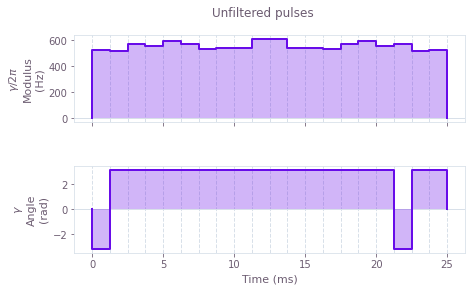

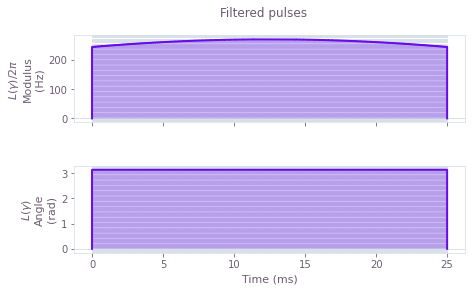

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization has started.
Your task calculate_optimization has completed in 198s.
Optimized cost:	 0.002338317487898654


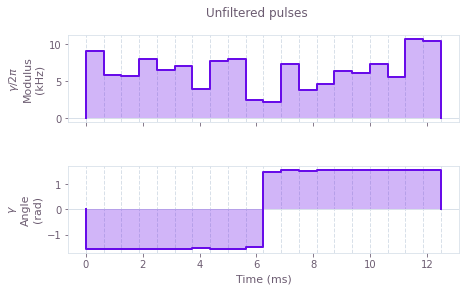

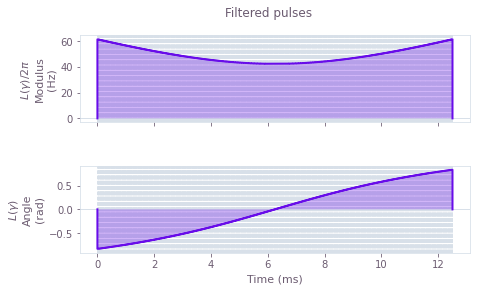

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_graph has completed in 3s.


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_graph has started.
Your task calculate_graph has completed in 6s.


In [35]:
not_values = get_optimal_pulse(sigma_x, duration=not_duration)
h_values = get_optimal_pulse(hadamard, duration=h_duration)

not_results = simulate_more_realistic_qubit(
    duration=not_duration, values=not_values, shots=shots
)
h_results = simulate_more_realistic_qubit(
    duration=h_duration, values=h_values, shots=shots
)

In [36]:
error_norm = (
    lambda operate_a, operator_b: 1
    - np.abs(np.trace((operate_a.conj().T @ operator_b)) / 2) ** 2
)

In [37]:
def get_pulse_plot_dict(name="default", duration=1, values=np.array([1.0])):
    segments = len(values)
    segment_durations = duration / segments
    pulse_plot_dict = {
        name: [{"duration": segment_durations, "value": v} for v in values]
    }
    return pulse_plot_dict
def estimate_probability_of_one(measurements):
    size = len(measurements)
    probability = np.mean(measurements)
    standard_error = np.std(measurements) / np.sqrt(size)
    return (probability, standard_error)

In [38]:
realised_not_gate = not_results["unitary"]
ideal_not_gate = np.array([[0, 1], [1, 0]]) * -1j
not_error = error_norm(realised_not_gate, ideal_not_gate)
realised_h_gate = h_results["unitary"]
ideal_h_gate = (1 / np.sqrt(2)) * np.array([[1, -1j], [-1j, 1]])
ideal_h_gate = (1 / np.sqrt(2)) * np.array([[1, 1], [1, -1]]) * -1j
h_error = error_norm(realised_h_gate, ideal_h_gate)

not_measurements = not_results["measurements"]
h_measurements = h_results["measurements"]
not_probability, not_standard_error = estimate_probability_of_one(not_measurements)
h_probability, h_standard_error = estimate_probability_of_one(h_measurements)

print("Realised NOT Gate:")
print(realised_not_gate)
print("Ideal NOT Gate:")
print(ideal_not_gate)
print("NOT Gate Error:" + str(not_error))
print("NOT estimated probability of getting 1:" + str(not_probability))
print("NOT estimate standard error:" + str(not_standard_error) + "\n")

print("Realised H Gate:")
print(realised_h_gate)
print("Ideal H Gate:")
print(ideal_h_gate)
print("H Gate Error:" + str(h_error))
print("H estimated probability of getting 1:" + str(h_probability))
print("H estimate standard error:" + str(h_standard_error))

Realised NOT Gate:
[[ 0.0012657 -0.00813247j -0.15173403+0.98838709j]
 [-0.16112077+0.98690038j -0.00130932+0.00812556j]]
Ideal NOT Gate:
[[0.-0.j 0.-1.j]
 [0.-1.j 0.-0.j]]
NOT Gate Error:9.031938718495613e-05
NOT estimated probability of getting 1:0.984375
NOT estimate standard error:0.0038756122720672716

Realised H Gate:
[[ 0.05406221-0.70522089j  0.05545653-0.70474488j]
 [ 0.05547262-0.70474361j -0.05692424+0.70499565j]]
Ideal H Gate:
[[0.-0.70710678j 0.-0.70710678j]
 [0.-0.70710678j 0.+0.70710678j]]
H Gate Error:2.1272160173335664e-06
H estimated probability of getting 1:0.4970703125
H estimate standard error:0.015624731776796312


In [13]:
control_count = 5
segment_count = 16
duration = 30.0
shot_count = 32

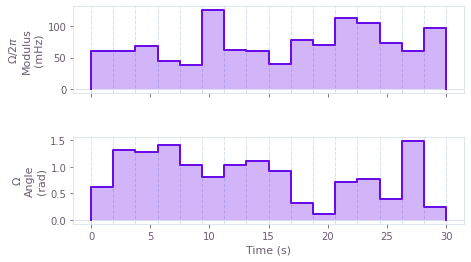

In [14]:
controls = []
for k in range(control_count):
    # Create a random string of complex numbers for each controls.
    real_part = np.random.random(size=[segment_count])
    imag_part = np.random.random(size=[segment_count])
    values = 0.15 * k * (real_part + 1j * imag_part)

    controls.append({"duration": duration, "values": values})

# Plot the last control as an example.
plot_controls(
    figure=plt.figure(),
    controls={
        "$\Omega$": [
            {"duration": duration / segment_count, "value": value} for value in values
        ]
    },
)

In [15]:
# Obtain the results of the experiment.
experiment_results = qctrl.functions.calculate_qchack_measurements(
    controls=controls,
    shot_count=shot_count,
)

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_qchack_measurements has completed in 3s.


In [16]:
measurements = experiment_results.measurements
for k, measurement_counts in enumerate(measurements):
    print(f"control #{k}: {measurement_counts}")

control #0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
control #1: [1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
control #2: [1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0]
control #3: [1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0]
control #4: [1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]


In [17]:
for k, measurement_counts in enumerate(measurements):
    p0 = measurement_counts.count(0) / shot_count
    p1 = measurement_counts.count(1) / shot_count
    p2 = measurement_counts.count(2) / shot_count
    print(f"control #{k}: P(|0>) = {p0:.2f}, P(|1>) = {p1:.2f}, P(|2>) = {p2:.2f}")

control #0: P(|0>) = 1.00, P(|1>) = 0.00, P(|2>) = 0.00
control #1: P(|0>) = 0.81, P(|1>) = 0.19, P(|2>) = 0.00
control #2: P(|0>) = 0.47, P(|1>) = 0.53, P(|2>) = 0.00
control #3: P(|0>) = 0.31, P(|1>) = 0.69, P(|2>) = 0.00
control #4: P(|0>) = 0.38, P(|1>) = 0.62, P(|2>) = 0.00


In [18]:
repetitions = [1, 4, 16, 32, 64]

controls = []
# Create a random string of complex numbers for all control,
# but set a different repetition_count for each control.
real_part = np.random.random(size=[segment_count])
imag_part = np.random.random(size=[segment_count])
values = 0.5 * (real_part + 1j * imag_part)

for repetition_count in repetitions:
    controls.append(
        {"duration": duration, "values": values, "repetition_count": repetition_count}
    )

experiment_results = qctrl.functions.calculate_qchack_measurements(
    controls=controls,
    shot_count=shot_count,
)

for repetition_count, measurement_counts in zip(
    repetitions, experiment_results.measurements
):
    p0 = measurement_counts.count(0) / shot_count
    p1 = measurement_counts.count(1) / shot_count
    p2 = measurement_counts.count(2) / shot_count
    print(
        f"With {repetition_count:2d} repetitions: P(|0>) = {p0:.2f}, P(|1>) = {p1:.2f}, P(|2>) = {p2:.2f}"
    )

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_qchack_measurements has completed in 3s.
With  1 repetitions: P(|0>) = 0.19, P(|1>) = 0.81, P(|2>) = 0.00
With  4 repetitions: P(|0>) = 0.22, P(|1>) = 0.78, P(|2>) = 0.00
With 16 repetitions: P(|0>) = 0.59, P(|1>) = 0.41, P(|2>) = 0.00
With 32 repetitions: P(|0>) = 0.03, P(|1>) = 0.97, P(|2>) = 0.00
With 64 repetitions: P(|0>) = 0.97, P(|1>) = 0.03, P(|2>) = 0.00
